## CT Scan Simulator

In [22]:
import os
from ipywidgets import Dropdown, IntSlider, interactive_output
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
import datetime
import pydicom
from pydicom.dataset import FileDataset, FileMetaDataset
from pydicom.uid import ExplicitVRLittleEndian, generate_uid, MRImageStorage



### Image selection

In [2]:
def on_image_change(change):
    global selected_image
    selected_image = change['new']


selected_image = "Shepp_logan.jpg"

images = ["CT_ScoutView.jpg", 
          "CT_ScoutView-large.jpg", 
          "Kolo.jpg", 
          "Kropka.jpg", 
          "Kwadraty2.jpg", 
          "Paski2.jpg", 
          "SADDLE_PE.JPG", 
          "SADDLE_PE-large.JPG", 
          "Shepp_logan.jpg"]

dropdown = Dropdown(
    options=images,
    value="Shepp_logan.jpg",
    description="Obraz:"
)

dropdown.observe(on_image_change, names='value')
display(dropdown)


Dropdown(description='Obraz:', index=8, options=('CT_ScoutView.jpg', 'CT_ScoutView-large.jpg', 'Kolo.jpg', 'Kr…

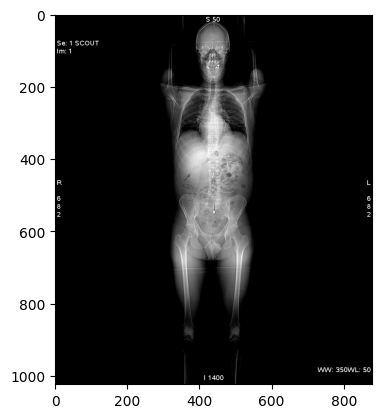

In [27]:
image_path = os.path.join("images", selected_image)

image = imread(image_path, as_gray=True)
plt.imshow(image, cmap="gray")
plt.show()


### Setting the positions of the emitters and detectors

In [28]:
def get_detectors_coordinates(alpha, angle_range, num_detectors, radius, center):
    start_angle = alpha - angle_range / 2
    angles = np.linspace(0, angle_range, num_detectors) + start_angle

    cx, cy = center
    x = radius * np.cos(np.radians(angles)) - cx
    y = radius * np.sin(np.radians(angles)) - cy

    coordinates = np.floor(np.array(list(zip(x, y)))).astype(int)
    return coordinates

def get_emitters_coordinates(alpha, angle_range, num_detectors, radius, center):
    start_angle = alpha - angle_range / 2 + 180
    angles = np.linspace(0, angle_range, num_detectors) + start_angle
    
    cx, cy = center
    x = radius * np.cos(np.radians(angles)) - cx
    y = radius * np.sin(np.radians(angles)) - cy

    coordinates = np.floor(np.array(list(zip(x, y)))).astype(int)
    return coordinates[::-1]


### Bresenham's algorithm

In [5]:
def bresenham_line(x0, y0, x1, y1):
    x0, y0, x1, y1 = int(round(x0)), int(round(y0)), int(round(x1)), int(round(y1))
    points = []

    dx = abs(x1 - x0)
    dy = abs(y1 - y0)

    x, y = x0, y0

    # Determining the direction
    if x0 > x1:
        sx = -1
    else:
        sx = 1

    if y0 > y1:
        sy = -1
    else:
        sy = 1

    if dx > dy:  # Horizontal line
        err = dx / 2.0
        while x != x1:  # Loop iterating through all points on the line
            points.append((x, y))
            err -= dy
            if err < 0:
                y += sy  # If the error is less than 0, move y
                err += dx
            x += sx  # Increase x by one step in the appropriate direction
    else:  # Vertical line
        err = dy / 2.0
        while y != y1:
            points.append((x, y))
            err -= dx
            if err < 0:
                x += sx  # If the error is less than 0, move x
                err += dy
            y += sy  # Increase y by one step in the appropriate direction

    points.append((x, y))

    # TTransposing the array to get list of x and y coordinates
    return np.array(points).T


### Radom transform

In [6]:
# Normalizing the values in the array to the range [0, 1]
def normalize_range(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))


# Extend the matrix with zeros so that its new size fits into the circle 
def pad_image(image):
    height, width = image.shape

    size = int(np.ceil(np.sqrt(height**2 + width**2)))

    pad_y = (size - height) / 2
    pad_x = (size - width) / 2
    pad = [
        (int(np.floor(pad_y)), int(np.ceil(pad_y))),
        (int(np.floor(pad_x)), int(np.ceil(pad_x)))
    ]

    return np.pad(image, pad, mode='constant', constant_values=0)


def remove_image_pad(img, height, width):
    y, x = img.shape  # Dimensions of the input image

    start_x = x // 2 - width // 2
    start_y = y // 2 - height // 2

    return img[start_y:start_y + height, start_x:start_x + width]

import numpy as np

def rescale_intensity(image, in_range=(0, 1), out_range=(0, 1)):
    # Convert to float for calculations
    image = image.astype(np.float64)
    
    # Clip values to the input range
    low, high = in_range
    image = np.clip(image, low, high)
    
    # Rescale to output range
    out_low, out_high = out_range
    if high != low:  # Avoid division by zero
        image = (image - low) * (out_high - out_low) / (high - low) + out_low
    else:
        image = np.zeros_like(image) + out_low  # All values same if input range is zero
    
    return image


def visualize_sinogram(sinogram):
    plt.clf()
    plt.imshow(np.swapaxes(sinogram, 0, 1), cmap="gray")
    plt.title("Sinogram")
    display(plt.gcf())
    clear_output(wait=True)


# Single image scan for a given angle alpha
def scan(image, alpha, angle_range, num_detectors, radius, center):
    emitters_coordinates = get_emitters_coordinates(alpha, angle_range, num_detectors, radius, center)
    detectors_coordinates = get_detectors_coordinates(alpha, angle_range, num_detectors, radius, center)
    
    # Determining the path for each emitter-detector pair
    lines = [np.array(bresenham_line(x1, y1, x0, y0)) for (x0, y0), (x1, y1) in zip(emitters_coordinates, detectors_coordinates)]
    
    # Calculating the sum of pixel values along each path
    projections = [np.sum(image[tuple(line)]) for line in lines]
    
    return normalize_range(projections)


def radon_transform(image, num_scans, num_detectors, angle_range, visualize=False):
    image = normalize_range(image)
    image = pad_image(image)
    image_center = np.floor(np.array(image.shape) / 2).astype(int)
    radius =image.shape[0] // 2  # Radius of the circle on which the emitters and detectors are placed

    alphas = np.linspace(0, 180, num_scans)  # List of angles for which the scans will be done
    sinogram = np.zeros((num_scans, num_detectors))
    visualization = []

    for i, alpha in enumerate(alphas):
        image_scan = scan(image, alpha, angle_range, num_detectors, radius, image_center)
        sinogram[i] = image_scan
        
        if visualize:
            visualization.append(sinogram.copy())

    if visualize:
        return sinogram, visualization
    else:
        return sinogram


In [7]:
def on_num_scans_change(change):
    global num_scans
    num_scans = change['new']


def on_num_detectors_change(change):
    global num_detectors
    num_detectors = change['new']


def on_angle_range_change(change):
    global angle_range
    angle_range = change['new']


def on_visualize_change(change):
    global visualize_scanning
    if change['new'] == "Tak":
        visualize_scanning = True
    else:
        visualize_scanning = False


num_scans = 180
num_detectors = 180
angle_range = 180
visualize_scanning = False

num_scans_widget = IntSlider(value=180, min=90, max=720, step=90, description="Liczba skanów:", disabled=False)
num_detectors_widget = IntSlider(value=180, min=90, max=720, step=90, description="Liczba detektorów:", disabled=False)
angle_range_widget = IntSlider(value=180, min=45 , max=270 , step=45 , description="Rozpiętość wachlarza:", disabled=False)
visualize_dropdown = Dropdown(
    options=["Tak", "Nie"],
    value="Nie",
    description="Wizualizuj: "
)

num_scans_widget.observe(on_num_scans_change, names='value')
num_detectors_widget.observe(on_num_detectors_change, names='value')
angle_range_widget.observe(on_angle_range_change, names='value')
visualize_dropdown.observe(on_visualize_change, names='value')
display(num_scans_widget, num_detectors_widget, angle_range_widget, visualize_dropdown)


IntSlider(value=180, description='Liczba skanów:', max=720, min=90, step=90)

IntSlider(value=180, description='Liczba detektorów:', max=720, min=90, step=90)

IntSlider(value=180, description='Rozpiętość wachlarza:', max=270, min=45, step=45)

Dropdown(description='Wizualizuj: ', index=1, options=('Tak', 'Nie'), value='Nie')

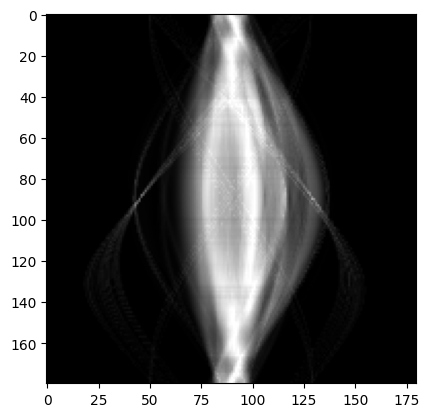

In [29]:
def plot_visualization(index):
    index = min(index, len(visualization) - 1)
    plt.imshow(visualization[index], cmap='gray')
    plt.axis('off')
    plt.show()
    

if visualize_scanning:
    sinogram, visualization = radon_transform(image, num_scans, num_detectors, angle_range, visualize=visualize_scanning)
    index_slider = IntSlider(value=1, min=1, max=len(sinogram), step=1, description="Postęp obrotu:")
    ui = interactive_output(plot_visualization, {'index': index_slider})
    display(index_slider, ui)
else:
    sinogram = radon_transform(image, num_scans, num_detectors, angle_range, visualize=visualize_scanning)
    plt.imshow(sinogram, cmap="gray")

### Sinogram filtering

In [9]:
def apply_mask(detectors):
    mask_size = int(np.floor(detectors / 2))  # Convert to integer
    mask = np.zeros(mask_size)
    center = int(np.floor(mask_size / 2))  # Also convert center to integer

    for i in range(0, mask_size, 1):
        k = i - center
        if k % 2 != 0:
            mask[i] = (-4 / np.pi ** 2) / k ** 2

    mask[center] = 1
    return mask

def sinogram_filtering(sinogram):
    sinogram_shape = np.shape(sinogram)
    no_of_projections = sinogram_shape[0]
    no_of_detectors = sinogram_shape[1]

    filtered = np.zeros((no_of_projections, no_of_detectors))
    mask = apply_mask(no_of_detectors)

    for projection in range(no_of_projections):
        filtered[projection] = np.convolve(sinogram[projection], mask, mode="same")

    
    return filtered


### Inverse Radon transform

In [10]:
def reconstruct_image(image, scan_count, scan, alpha, angle_range, num_detectors, radius=1, center=(1,1)):
    emitters_coordinates = get_emitters_coordinates(alpha, angle_range, num_detectors, radius, center)
    detectors_coordinates = get_detectors_coordinates(alpha, angle_range, num_detectors, radius, center)
    
    # Determining the path for each emitter-detector pair
    lines = [np.array(bresenham_line(x1, y1, x0, y0)) for (x0, y0), (x1, y1) in zip(emitters_coordinates, detectors_coordinates)]
    
    # Increasing the pixel value along the radiation path and the scan counter
    for i, line in enumerate(lines):
        image[tuple(line)] += scan[i]
        scan_count[tuple(line)] += 1

    return image, scan_count

def inverse_radon_transform(image_shape, sinogram, angle_range, filtering=False, visualize=False, kernel_size=9):
    num_scans, num_detectors = sinogram.shape
    
    image_reconstructed = pad_image(np.zeros(image_shape))
    scan_count = np.zeros(image_reconstructed.shape)

    image_center = np.floor(np.array(image_reconstructed.shape) / 2).astype(int)
    radius = image_reconstructed.shape[0] // 2
    alphas = np.linspace(0, 180, num_scans)

    if filtering:
        sinogram = sinogram_filtering(sinogram)

    visualization_inverse = []
    
    for i, alpha in enumerate(alphas):
        image_reconstructed, scan_count = reconstruct_image(
            image_reconstructed,
            scan_count,
            sinogram[i],
            alpha, 
            angle_range,
            num_detectors,
            radius,
            image_center
        )

        if visualize:
            visualization_inverse.append(image_reconstructed.copy())

    scan_count[scan_count == 0] = 1  # Zero division protection
    image_reconstructed /= scan_count  # Dividing by the scan count
    image_reconstructed_scaled = normalize_range(image_reconstructed)  # Normalizing to the range [0, 1]
    image_reconstructed_scaled = remove_image_pad(image_reconstructed_scaled, *image_shape)   # Removing padding

    x, y = np.percentile(image_reconstructed_scaled, (20, 98))
    image_reconstructed_enhanced = rescale_intensity(image_reconstructed_scaled, (x, y))

    if visualize:
        return image_reconstructed_enhanced, visualization_inverse
    else:
        return image_reconstructed_enhanced


In [11]:
def on_visualize_change(change):
    global visualize_inverse
    if change['new'] == "Tak":
        visualize_inverse = True
    else:
        visualize_inverse = False


def on_filter_change(change):
    global filter_sinogram
    if change['new'] == "Tak":
        filter_sinogram = True
    else:
        filter_sinogram = False


visualize_inverse = False
filter_sinogram = False

filter_dropdown = Dropdown(
    options=["Tak", "Nie"],
    value="Nie",
    description="Filtruj sinogram: "
)
visualize_inverse_dropdown = Dropdown(
    options=["Tak", "Nie"],
    value="Nie",
    description="Wizualizuj: "
)

filter_dropdown.observe(on_filter_change, names='value')
visualize_inverse_dropdown.observe(on_visualize_change, names='value')
display(filter_dropdown, visualize_inverse_dropdown)


Dropdown(description='Filtruj sinogram: ', index=1, options=('Tak', 'Nie'), value='Nie')

Dropdown(description='Wizualizuj: ', index=1, options=('Tak', 'Nie'), value='Nie')

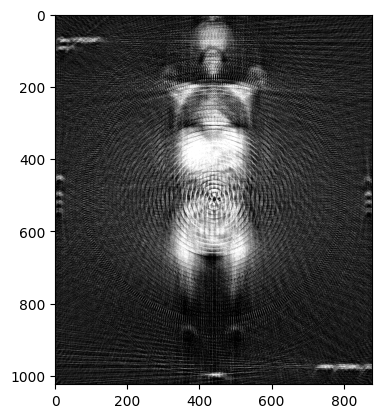

In [30]:
def plot_inverse_visualization(index):
    index = min(index, len(visualization_inverse) - 1)
    plt.imshow(visualization_inverse[index], cmap='gray')
    plt.axis('off')
    plt.show()

if visualize_inverse:
    reconstructed_image, visualization_inverse = inverse_radon_transform(image.shape, sinogram, angle_range, filtering=filter_sinogram, visualize=visualize_inverse)
    index_slider = IntSlider(value=1, min=1, max=len(visualization_inverse), step=1, description="Postęp obrotu:")
    ui = interactive_output(plot_inverse_visualization, {'index': index_slider})
    display(index_slider, ui)
else:
    reconstructed_image = inverse_radon_transform(image.shape, sinogram, angle_range, filtering=filter_sinogram, visualize=visualize_inverse)
    plt.imshow(reconstructed_image, cmap="gray")

### DICOM Files

In [23]:
def read_dicom_file(path):
    try:
        ds = pydicom.dcmread(path)
        keys = {x for x in dir(ds) if x[0].isupper()}
        keys -= {'PixelData'}
        meta_data = {x: getattr(ds, x) for x in keys}

        if 'PixelData' in ds:
            image = ds.pixel_array
        else:
            image = np.array([])

        return image, meta_data
    except Exception as e:
        raise IOError("Failed to read file")

{'PixelRepresentation': 0,
 'Rows': 1024,
 'PatientID': '123',
 'SeriesInstanceUID': '1.2.826.0.1.3680043.8.498.2563460541797574898731899131855621367',
 'SamplesPerPixel': 1,
 'StudyDate': '20250101',
 'PhotometricInterpretation': 'MONOCHROME2',
 'Columns': 880,
 'PatientName': 'Jane Doe',
 'SOPClassUID': '1.2.840.10008.5.1.4.1.1.4',
 'ImageComments': 'Great Image',
 'BitsAllocated': 16,
 'HighBit': 15,
 'StudyInstanceUID': '1.2.826.0.1.3680043.8.498.56530448470021499819659092351029067604',
 'BitsStored': 16,
 'Modality': 'MR',
 'FrameOfReferenceUID': '1.2.826.0.1.3680043.8.498.39727464188644339298368210905120156520'}

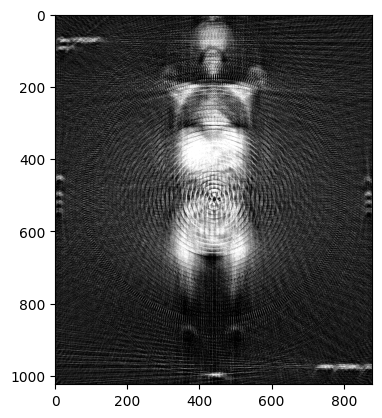

In [32]:
image_dcm, meta_data = read_dicom_file("wynik.dcm")
plt.imshow(image_dcm, cmap="gray")
meta_data


In [18]:
def write_dicom_file(path, image_array, meta_data):

    if image_array.dtype != np.uint16:
        image_array = ((image_array - image_array.min()) / (image_array.max() - image_array.min()) * 65535).astype(np.uint16)


    file_meta = FileMetaDataset()
    file_meta.MediaStorageSOPClassUID = MRImageStorage
    file_meta.MediaStorageSOPInstanceUID = generate_uid()
    file_meta.TransferSyntaxUID = ExplicitVRLittleEndian

    ds = FileDataset(path, {}, file_meta=file_meta, preamble=b"\0" * 128)
    ds.is_little_endian = True
    ds.is_implicit_VR = False

    ds.SOPClassUID = MRImageStorage
    ds.StudyDate = datetime.datetime.now().strftime('%Y%m%d')
    ds.SeriesInstanceUID = generate_uid()
    ds.StudyInstanceUID = generate_uid()
    ds.FrameOfReferenceUID = generate_uid()

    for key, value in meta_data.items():
        try:
            setattr(ds, key, value)
        except Exception:
            pass 

    if image_array is not None and image_array.size > 0:
        ds.Rows, ds.Columns = image_array.shape
        ds.SamplesPerPixel = 1
        ds.PhotometricInterpretation = "MONOCHROME2"
        ds.BitsStored = 16
        ds.BitsAllocated = 16
        ds.HighBit = 15
        ds.PixelRepresentation = 0
        ds.PixelData = image_array.astype(np.uint16).tobytes()

    ds.save_as(path, write_like_original=False)
    print(f"Saved to file {path}")


In [31]:
patient_data = {
    "PatientName": "Jane Doe",
    "PatientID": "123",
    "Modality": "MR",
    "ImageComments": "A comment",
    "StudyDate": "20250101"
}


write_dicom_file("wynik.dcm", reconstructed_image, meta_data)


Saved to file wynik.dcm


### Statistical Analysis

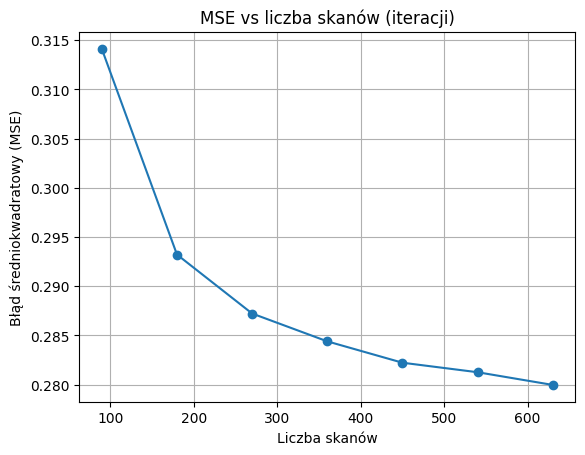

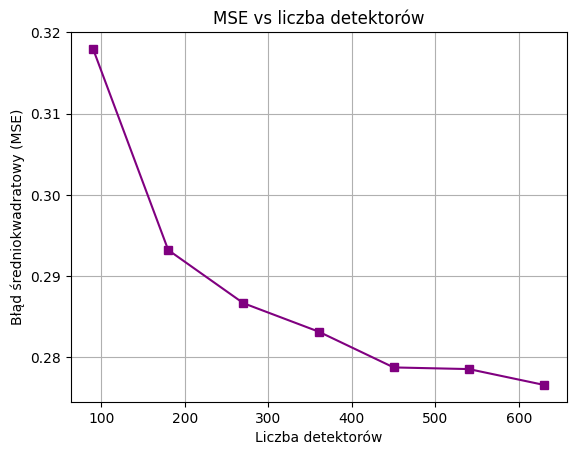

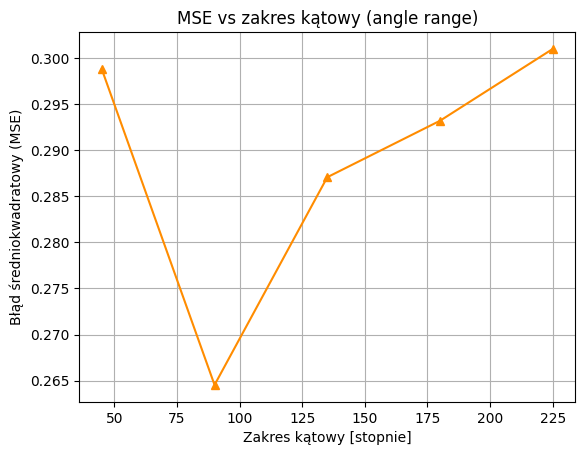

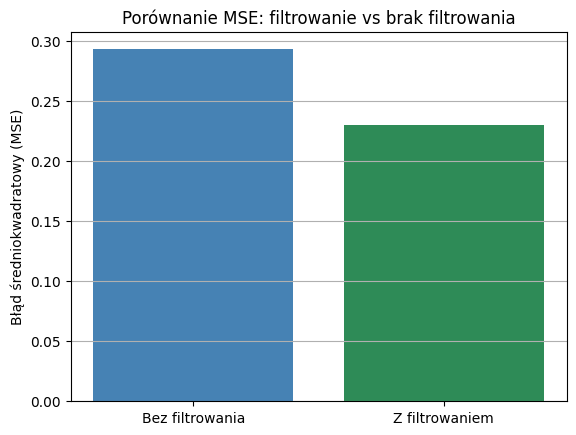

MSE bez filtrowania: 0.29321
MSE z filtrowaniem:  0.23004


In [33]:
def calculate_mse(predictions, targets):
    predictions = normalize_range(predictions)
    targets = normalize_range(targets)
    return np.sqrt(np.mean((predictions - targets) ** 2))


def analyze_mse_vs_scans(original_image, num_detectors, angle_range):
    scan_counts = range(90, 720, 90)
    errors = []

    for scans in scan_counts:
        sinogram = radon_transform(original_image, scans, num_detectors, angle_range)
        reconstructed = inverse_radon_transform(original_image.shape, sinogram, angle_range, visualize=False)
        error = calculate_mse(reconstructed, original_image)
        errors.append(error)

    plt.figure()
    plt.plot(scan_counts, errors, marker='o')
    plt.title("MSE vs liczba skanów (iteracji)")
    plt.xlabel("Liczba skanów")
    plt.ylabel("Błąd średniokwadratowy (MSE)")
    plt.grid(True)
    plt.show()

def analyze_mse_vs_detectors(original_image, scan_count, angle_range):
    detector_counts = range(90, 720, 90) 
    errors = []

    for num_detectors in detector_counts:
        sinogram = radon_transform(original_image, scan_count, num_detectors, angle_range)
        reconstructed = inverse_radon_transform(original_image.shape, sinogram, angle_range, visualize=False)
        error = calculate_mse(reconstructed, original_image)
        errors.append(error)

    plt.figure()
    plt.plot(detector_counts, errors, marker='s', color='purple')
    plt.title("MSE vs liczba detektorów")
    plt.xlabel("Liczba detektorów")
    plt.ylabel("Błąd średniokwadratowy (MSE)")
    plt.grid(True)
    plt.show()

def analyze_mse_vs_angle_range(original_image, scan_count, num_detectors):
    angle_ranges = range(45, 270, 45)
    errors = []

    for angle_range in angle_ranges:
        sinogram = radon_transform(original_image, scan_count, num_detectors, angle_range)
        reconstructed = inverse_radon_transform(original_image.shape, sinogram, angle_range, visualize=False)
        error = calculate_mse(reconstructed, original_image)
        errors.append(error)

   
    plt.figure()
    plt.plot(angle_ranges, errors, marker='^', color='darkorange')
    plt.title("MSE vs zakres kątowy (angle range)")
    plt.xlabel("Zakres kątowy [stopnie]")
    plt.ylabel("Błąd średniokwadratowy (MSE)")
    plt.grid(True)
    plt.show()

def analyze_mse_with_and_without_filtering(original_image, scan_count, num_detectors, angle_range):
    sinogram = radon_transform(original_image, scan_count, num_detectors, angle_range)

    reconstructed_no_filter = inverse_radon_transform(
        original_image.shape,
        sinogram,
        angle_range,
        filtering=False,
        visualize=False
    )
    mse_no_filter = calculate_mse(reconstructed_no_filter, original_image)

    reconstructed_filtered = inverse_radon_transform(
        original_image.shape,
        sinogram,
        angle_range,
        filtering=True,
        visualize=False
    )
    mse_filtered = calculate_mse(reconstructed_filtered, original_image)

    labels = ['Bez filtrowania', 'Z filtrowaniem']
    errors = [mse_no_filter, mse_filtered]

    plt.figure()
    plt.bar(labels, errors, color=['steelblue', 'seagreen'])
    plt.title("Porównanie MSE: filtrowanie vs brak filtrowania")
    plt.ylabel("Błąd średniokwadratowy (MSE)")
    plt.grid(axis='y')
    plt.show()

    print(f"MSE bez filtrowania: {mse_no_filter:.5f}")
    print(f"MSE z filtrowaniem:  {mse_filtered:.5f}")

def analyze_mse_during_iterations(original_image, num_detectors, num_scans, angle_range, filtering=False): 
    sinogram = radon_transform(image, num_scans, num_detectors, angle_range)

    image_reconstructed = pad_image(np.zeros(original_image.shape))
    scan_count = np.zeros(image_reconstructed.shape)

    image_center = np.floor(np.array(image_reconstructed.shape) / 2).astype(int)
    radius = image_reconstructed.shape[0] // 2
    alphas = np.linspace(0, 180, num_scans)

    if filtering:
        sinogram = sinogram_filtering(sinogram)

    mse_list = []

    for i, alpha in enumerate(alphas):
        image_reconstructed, scan_count = reconstruct_image(
            image_reconstructed,
            scan_count,
            sinogram[i],
            alpha,
            angle_range,
            num_detectors,
            radius,
            image_center
        )

        # Temperary reconstruction
        temp_reconstructed = image_reconstructed / np.where(scan_count == 0, 1, scan_count)
        temp_scaled = normalize_range(temp_reconstructed)
        temp_unpadded = remove_image_pad(temp_scaled, *original_image.shape)
        mse = calculate_mse(temp_unpadded, original_image)
        mse_list.append(mse)

    plt.figure()
    plt.plot(range(1, num_scans + 1), mse_list, marker='o', linestyle='-')
    plt.title("Zmiana MSE podczas iteracji odwrotnej transformaty Radona")
    plt.xlabel("Numer iteracji (kąt skanowania)")
    plt.ylabel("Błąd średniokwadratowy (MSE)")
    plt.grid(True)
    plt.show()



analyze_mse_vs_scans(image, num_detectors, angle_range)
analyze_mse_vs_detectors(image, num_scans, angle_range)
analyze_mse_vs_angle_range(image, num_scans, num_detectors)
analyze_mse_with_and_without_filtering(image, num_scans, num_detectors, angle_range)
#analyze_mse_during_iterations(image, num_detectors, num_scans, angle_range, filter_sinogram)